# Part 4 · Model Optimization & Analysis

This notebook explores strategies to improve the alpha model's performance, starting with an analysis of rebalancing frequency.

In [1]:
from pathlib import Path
import sys
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

import src.config as config
import src.backtest as backtest

importlib.reload(config)
importlib.reload(backtest)

sns.set_theme(style='whitegrid')
config.ensure_directories()

{'artifacts': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts'),
 'feature_store': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/features'),
 'models': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/models'),
 'plots': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/plots'),
 'reports': PosixPath('/home/navey/precogquanttask/model_pipeline/artifacts/reports')}

## 1. Load Data

Load the feature panel and alpha signals generated in the previous notebooks.

In [2]:
feature_panel = pd.read_parquet(config.FEATURE_STORE_PATH).reset_index()
alphas = pd.read_parquet(config.ALPHA_STORE_PATH).reset_index()
alphas_smoothed = pd.read_parquet(config.ALPHA_STORE_SMOOTHED).reset_index()


print("Feature panel shape:", feature_panel.shape)
print("Alphas shape:", alphas.shape)
print("Smoothed Alphas shape:", alphas_smoothed.shape)
alphas_smoothed.head()

Feature panel shape: (234800, 41)
Alphas shape: (234800, 3)
Smoothed Alphas shape: (234800, 4)


,Date,Asset,alpha_signal,alpha_signal_smoothed
0,2017-01-11,Asset_001,0.003084,0.003084
1,2017-01-11,Asset_002,0.003278,0.003278
2,2017-01-11,Asset_003,0.004533,0.004533
3,2017-01-11,Asset_004,0.003588,0.003588
4,2017-01-11,Asset_005,-0.008495,-0.008495


## 2. Run Backtests: Daily vs. Weekly Rebalancing

Compare the performance of the strategy when rebalanced daily versus weekly.

In [3]:
# Daily rebalancing (our baseline)
daily_cfg = backtest.BacktestConfig(rebalance_frequency='D')
daily_results = backtest.run_long_short_backtest(feature_panel, alphas, config=daily_cfg)

# Weekly rebalancing
weekly_cfg = backtest.BacktestConfig(rebalance_frequency='W')
weekly_results = backtest.run_long_short_backtest(feature_panel, alphas, config=weekly_cfg)

# Weekly rebalancing with smoothed signal
smoothed_cfg = backtest.BacktestConfig(
    rebalance_frequency='W',
    signal_column='alpha_signal_smoothed'
)
smoothed_results = backtest.run_long_short_backtest(feature_panel, alphas_smoothed, config=smoothed_cfg)


# Compare metrics
comparison = pd.DataFrame({
    'Daily': daily_results['metrics'],
    'Weekly': weekly_results['metrics'],
    'Weekly_Smoothed': smoothed_results['metrics']
})
comparison.loc[['sharpe', 'total_return', 'max_drawdown', 'avg_turnover']]

,Daily,Weekly,Weekly_Smoothed
sharpe,3.772412,5.377569,4.792646
total_return,31.554301,104.172353,68.758805
max_drawdown,-0.388179,-0.112193,-0.146746
avg_turnover,0.666781,0.189147,0.161906


## 3. Visualize Results

Plot the equity curves and turnover to visually assess the impact of the rebalancing frequency.

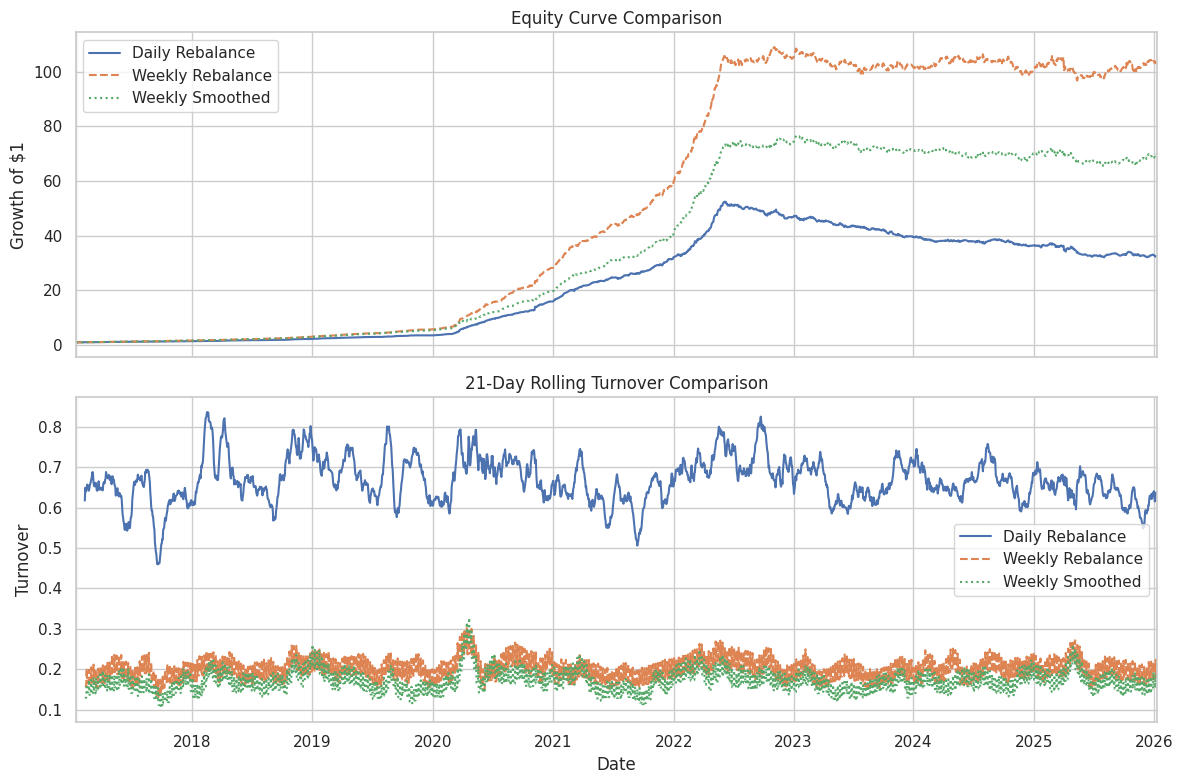

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Equity curves
daily_results['timeline']['equity_curve'].plot(ax=ax[0], label='Daily Rebalance')
weekly_results['timeline']['equity_curve'].plot(ax=ax[0], label='Weekly Rebalance', linestyle='--')
smoothed_results['timeline']['equity_curve'].plot(ax=ax[0], label='Weekly Smoothed', linestyle=':')
ax[0].set_title('Equity Curve Comparison')
ax[0].set_ylabel('Growth of $1')
ax[0].legend()

# Turnover
daily_results['timeline']['turnover'].rolling(21).mean().plot(ax=ax[1], label='Daily Rebalance')
weekly_results['timeline']['turnover'].rolling(21).mean().plot(ax=ax[1], label='Weekly Rebalance', linestyle='--')
smoothed_results['timeline']['turnover'].rolling(21).mean().plot(ax=ax[1], label='Weekly Smoothed', linestyle=':')
ax[1].set_title('21-Day Rolling Turnover Comparison')
ax[1].set_ylabel('Turnover')
ax[1].legend()

plt.tight_layout()
plt.show()